In [ ]:
# %pip install opencv-python
%pip install imageio[ffmpeg]
%pip install tqdm

In [1]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/RGB_data_stream'

Mounted at /content/gdrive


In [2]:
import os

csv_path = os.path.join(base_path,'data/3DYoga90.csv')
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')
save_path = os.path.join(base_path, 'save')
os.makedirs(save_path, exist_ok=True)
pose_list = ['mountain', 'half-way-lift', 'standing-forward-bend', 'downward-dog']
NUM_CLASSES = len(pose_list)
video_dir = os.path.join(base_path, 'short')

In [3]:
# Constants
FRAME_HEIGHT = 224  # VGG16 input size
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 16

BATCH_SIZE = 16
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 20

# Dataset

Work Left
1. Data Augmentation
2. Expanding to more classes

In [4]:
import pandas as pd
import os
import torch
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        # Keep only downloaded sequences
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        # Keep only required classes
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_idx = {pose: idx for idx, pose in enumerate(pose_list)}

        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return self.length_of_dataset

    def print(self):
        print(len(self.df))
        print(self.pose_to_idx)
        print(len(self))

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        # print(sequence_id)
        video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
        pose = self.df.iloc[i]['l3_pose']

        label = torch.zeros(NUM_CLASSES)
        label[self.pose_to_idx[pose]] = 1

        frames = self._get_frames(video_path)
        # print(frames.shape)

        return frames, label

    def _get_frames(self, video_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        total_frames = reader.count_frames()
        # print(total_frames)
        indices = np.linspace(0, total_frames-1, SEQUENCE_LENGTH, dtype=int)

        frames = []
        for i, frame in enumerate(reader):
            if i in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)

        reader.close()
        frames = torch.stack([torch.tensor(np.array(f)) for f in frames])
        return frames

# Model
``` (VGG16 to get feature map and LSTM to go through the frame sequences)```

Work Left
1. Using only last time step output from LSTM to using average value, max value, using attention mechanism
2. Using other imagenet model to extract the feature map

In [5]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()
        # Load pretrained VGG16
        vgg = models.vgg16(pretrained=True)
        # Remove the last classifier layer
        self.features = nn.Sequential(*list(vgg.features.children()))

        # Freeze VGG16 parameters
        for param in self.features.parameters():
            param.requires_grad = False

        # # LSTM configuration
        # self.lstm = nn.LSTM(
        #     input_size=512*7*7,  # VGG16 output size
        #     hidden_size=512,
        #     num_layers=2,
        #     batch_first=True
        # )
                # LSTM
        self.lstm = nn.LSTM(
            input_size=512*7*7,  # VGG16 output size
            hidden_size=512,
            num_layers=2,
            batch_first=True,
            dropout=0.5
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()

        # Combine batch and sequence dimensions
        x = x.view(batch_size * seq_length, c, h, w)

        # Extract CNN features
        x = self.features(x)

        # Flatten the CNN output
        x = x.view(batch_size, seq_length, -1)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        # Use the last time step output
        x = lstm_out[:, -1, :]

        # Classify
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)  # for multi-class classification

In [6]:
from torch.utils.data import random_split

def train_val_test_split(dataset):
    total_size = len(dataset)
    test_size = int(TEST_SPLIT * total_size)
    val_size = int(VALIDATION_SPLIT * total_size)
    train_size = total_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

def create_data_loaders(train_dataset, val_dataset, test_dataset):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory = True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory = True
    )

    return train_loader, val_loader, test_loader

In [7]:
import matplotlib.pyplot as plt

def plot_training_curves(history, fsave='training_curves.png'):
    """Plot training curves including learning rate"""
    tsave = os.path.join(save_path, fsave)
    plt.style.use('seaborn')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot loss curves
    ax1.plot(history['train_loss'], label='Training Loss', marker='o')
    ax1.plot(history['val_loss'], label='Validation Loss', marker='o')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy curves
    ax2.plot(history['train_acc'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Plot learning rate
    ax3.plot(history['learning_rates'], label='Learning Rate', marker='o')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate over Time')
    ax3.set_yscale('log')
    ax3.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(tsave)
    plt.show()
    plt.close()  # Close the plot to free up memory

In [8]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [9]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [10]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history
    history = checkpoint.get('history', {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history

In [11]:
import torch
from torch.optim import lr_scheduler
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=50, patience=7, log_interval=10, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # model = torch.compile(model)
    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize early stopping
    # early_stopping = EarlyStopping(patience=patience)
    early_stopping = EarlyStopping(patience=7, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')
    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'learning_rates': []
    }
        # Load checkpoint if provided
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Store current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels) in train_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            _, labels_idx = torch.max(labels, 1)  # For one-hot encoded labels
            train_correct += (predicted == labels_idx).sum().item()
            train_total += labels.size(0)

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (batch_idx + 1),
                    'accuracy': 100.0 * train_correct / train_total
                })

        train_loss = train_loss / len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels) in val_loader_tqdm:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                _, labels_idx = torch.max(labels, 1)
                val_correct += (predicted == labels_idx).sum().item()
                val_total += labels.size(0)

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (batch_idx + 1),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        val_loss = val_loss / len(val_loader)
        val_acc = 100.0 * val_correct / val_total

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch+1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {current_lr}')


        save_checkpoint(model, optimizer, epoch, history, best_path=None)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(save_path, 'best_model.pth')
            save_checkpoint(model, optimizer, epoch, history, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names,spath=save_path, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            _, labels_idx = torch.max(labels, 1)

            # Calculate accuracy
            test_correct += (predicted == labels_idx).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels_idx.cpu().numpy())

    # Calculate metrics
    test_loss = test_loss / len(test_loader)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [ ]:
print("Loading Data")
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir)
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)
print("Finished Loading Data")

model = CNNLSTM(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training the model")
checkpoint_path = os.path.join(save_path, 'checkpath_model.pth')
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    NUM_EPOCHS,
    patience=7,
    log_interval=10,
    checkpoint_path=checkpoint_path
)
# Plot the training curves
plot_training_curves(history)
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
evaluate_model(model, test_loader, criterion, pose_list)

model_save_path = os.path.join(save_path, 'my_model.pth')
torch.save(model.state_dict(), model_save_path)

Loading Data
Finished Loading Data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training the model
Using device: cuda
Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/save/checkpath_model.pth


<ipython-input-11-2bc9d87acebe>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 16

Epoch 17/20
Current Learning Rate: 0.001


Validation: 100%|██████████| 9/9 [04:06<00:00, 27.40s/it, loss=1.21, accuracy=81.2]



Epoch 17/20 Summary:
Train Loss: 0.1047 | Train Acc: 96.91%
Val Loss: 1.3818 | Val Acc: 77.54%
Learning Rate: 0.001
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/checkpath_model.pth
Checkpoint saved at epoch 17
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/best_model.pth
Checkpoint saved at epoch 17
New best model saved! Validation Loss: 1.3818

Epoch 18/20
Current Learning Rate: 0.001


Validation: 100%|██████████| 9/9 [03:38<00:00, 24.30s/it, loss=0.678, accuracy=81.2]



Epoch 18/20 Summary:
Train Loss: 0.1375 | Train Acc: 96.71%
Val Loss: 0.9792 | Val Acc: 79.71%
Learning Rate: 0.001
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/checkpath_model.pth
Checkpoint saved at epoch 18
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/best_model.pth
Checkpoint saved at epoch 18
New best model saved! Validation Loss: 0.9792

Epoch 19/20
Current Learning Rate: 0.001


Validation: 100%|██████████| 9/9 [03:36<00:00, 24.00s/it, loss=1.56, accuracy=68.8]



Epoch 19/20 Summary:
Train Loss: 0.0900 | Train Acc: 97.12%
Val Loss: 1.2940 | Val Acc: 78.99%
Learning Rate: 0.001
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/checkpath_model.pth
Checkpoint saved at epoch 19

Epoch 20/20
Current Learning Rate: 0.001


Validation: 100%|██████████| 9/9 [03:32<00:00, 23.64s/it, loss=1.51, accuracy=75]



Epoch 20/20 Summary:
Train Loss: 0.1219 | Train Acc: 95.47%
Val Loss: 1.0474 | Val Acc: 76.09%
Learning Rate: 0.001
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/save/checkpath_model.pth
Checkpoint saved at epoch 20


<ipython-input-8-01896b636157>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Test Loss: 1.5080
Test Accuracy: 0.00%


### For evaluation, model was again loaded because previously evaluation function was wrong.

In [ ]:
import torch
print("Loading Data")
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir)
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

model = CNNLSTM(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()

load_path = os.path.join(save_path, 'my_model.pth')
model.load_state_dict(torch.load(load_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
evaluate_model(model, test_loader, criterion, pose_list)

Loading Data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint from /content/gdrive/MyDrive/RGB_data_stream/save/best_model_81.63.pth


<ipython-input-10-2bc9d87acebe>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Testing: 100%|██████████| 5/5 [01:39<00:00, 19.85s/

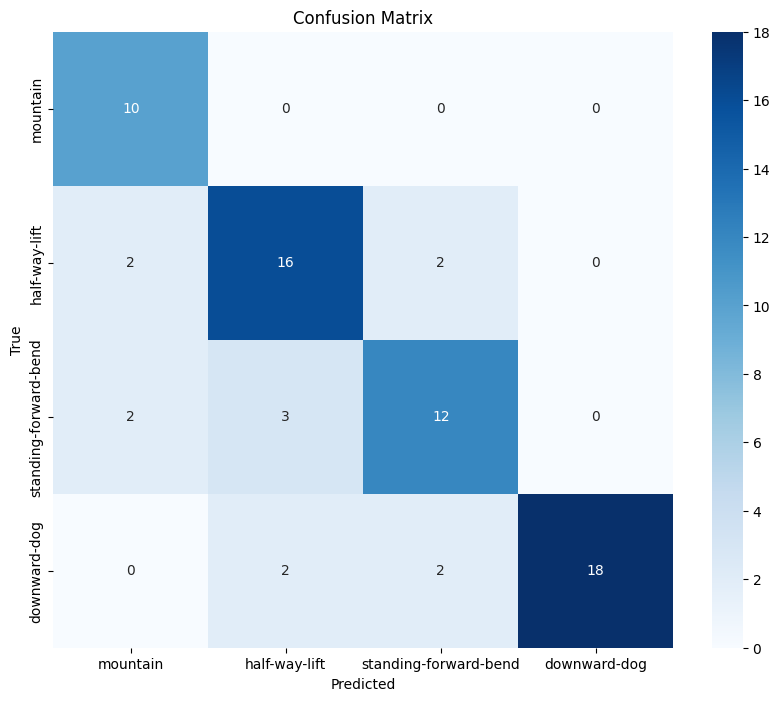

Test Loss: 1.0456
Test Accuracy: 81.16%


(1.0456256985664367, 81.15942028985508)

In [15]:
import torch
import os

best_save_path = os.path.join(save_path, 'eight')
os.makedirs(best_save_path, exist_ok = True)

print("Loading Data")
dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir)
train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

model = CNNLSTM(num_classes=NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

load_path = os.path.join(save_path, 'best_model_81.63.pth')
model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, load_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
evaluate_model(model, test_loader, criterion,pose_list, spath= best_save_path)